# 02 - GLMs for Classification
GLMs make excellent, flexible statistical models.  However, they also excel at making classification algorithms.  The purpose of this notebook is to illustrate how this might be done in Python.

I give three examples of how GLMs may be used for classification:
* Logistic regression
* Multinomial logistic regression
* Cumulative logistic regression

In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn.linear_model as skl

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Logistic Regression for Classification
#### Data:
For this example, I use the same data set from part 01: the `grad` data.  This is from [UCLA's IDRE module](https://stats.idre.ucla.edu/r/dae/logit-regression/), and here's its description:

 _A researcher is interested in how variables, such as GRE (Graduate Record Exam scores), GPA (grade point average) and prestige of the undergraduate institution, effect admission into graduate school. The response variable, admit/don’t admit, is a binary variable._

In [4]:
grad = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
grad.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [5]:
grad.admit.value_counts()

0    273
1    127
Name: admit, dtype: int64

In [6]:
# Split my data into training and test.
indep_vars = ['gre', 'gpa', 'rank']
x_train, x_test, y_train, y_test = train_test_split(grad[indep_vars],
                                                   grad.admit,
                                                   test_size = 0.3,
                                                   random_state = 1234)
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

In [7]:
# I build the same logistic regression model as from part 01.
# Logit link is assumed by default
glm_logit = sm.GLM(y_train, 
                   x_train,
                   sm.families.Binomial()).fit()

In [8]:
# The fitted values are stored as probabilities.
# i.e., They are the probabilities of the response variable being a "success" (coded as 1).
yhat_train = glm_logit.fittedvalues
yhat_train.head()

217    0.559869
349    0.360827
188    0.368102
267    0.312586
222    0.482989
dtype: float64

In [9]:
# I let my threshold value be 1/2, which is typical.
# So, any probability above 1/2 is more likely to be a "success", and anything below 1/2 is more likely to be a "failure".
# If you had some known reason, you could choose something besides 1/2, but that's rare.
p_thresh = 0.5
yhat_train = (yhat_train > p_thresh) * 1
yhat_train.head()

217    1
349    0
188    0
267    0
222    0
dtype: int32

In [10]:
# Training classification error
np.mean(yhat_train == y_train)

0.67500000000000004

In [11]:
# Test classification error
yhat_test = glm_logit.predict(x_test)
yhat_test = pd.Series(yhat_test)
yhat_test = (yhat_test > p_thresh) * 1
np.mean(yhat_test == y_test) # Not bad at all!

0.76666666666666672

### Multinomial Logistic Regression
Using GLMs to classify is not limited to binomial response data.  The multinomial distribution can be used to help classify a response variable with more than 2 levels (also known as "polytomous data").

Recall the formal definition of a $K$-class multinomial logistic regression:

$Y_i \sim \text{iid Mult}(1, \mathbf{\pi})$

$\log\left(\frac{p_1}{p_K}\right) = \beta_{01} + \beta_{11} x_1 + \cdots + \beta_{p1} x_p$

$\log\left(\frac{p_2}{p_K}\right) = \beta_{02} + \beta_{12} x_1 + \cdots + \beta_{p2} x_p$

$\cdots$

$\log\left(\frac{p_{K-1}}{p_K}\right) = \beta_{0K-1} + \beta_{1K-1} x_1 + \cdots + \beta_{pK-1} x_p$

#### Data
This time, I'm using the classic `iris` dataset.  In Python, this public-domain dataset can be found in the `seaborn` plotting package.  The data consist of four flower characteristcs, and the response variable, flower type.  There are 3 classes this can take.

In [12]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [13]:
# The class lables are the 'species'.  There are three.
iris.species.value_counts()

versicolor    50
setosa        50
virginica     50
Name: species, dtype: int64

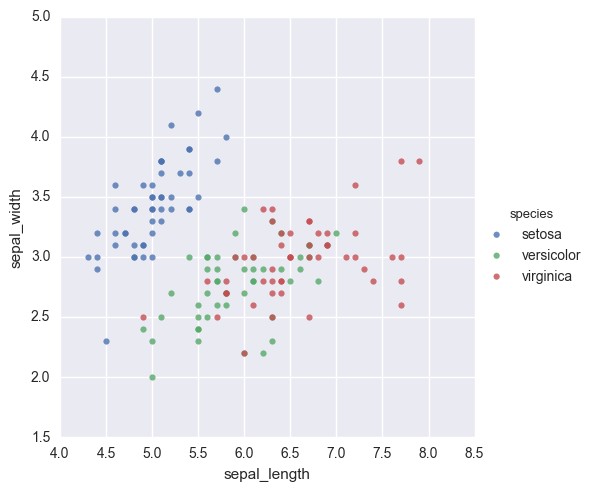

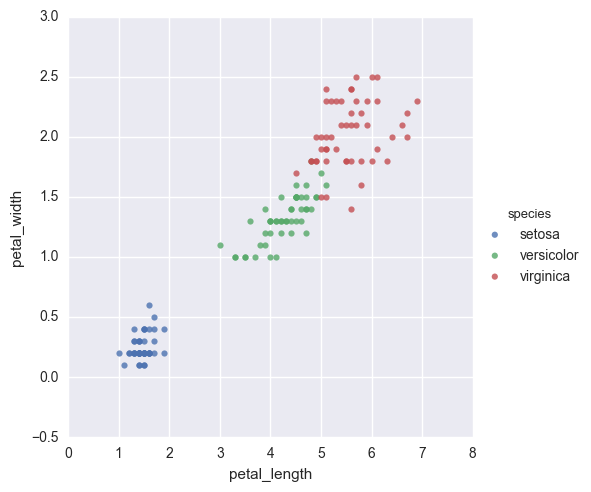

In [14]:
# Notice that these classes are VERY easy to separate.
sns.lmplot('sepal_length', 'sepal_width', 
           data = iris, 
           hue = 'species',
           fit_reg = False)

sns.lmplot('petal_length', 'petal_width', 
           data = iris, 
           hue = 'species',
           fit_reg = False)

In [54]:
# Training/Test split
# Purposefully not using all four variables
indep_vars = ['petal_length', 'petal_width']

x_train, x_test, y_train, y_test = train_test_split(iris[indep_vars],
                                                   iris.species,
                                                   test_size = 0.3,
                                                   random_state = 1234)

x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

In [60]:
# Train the model
# multi_logit = sm.MNLogit(y_train, x_train).fit()
# Note that this is regularized.  Even though that's not what I want, the sci-kit learn
# multinomial regression is much less bug-prone than statsmodel's.
multi_logit = skl.LogisticRegression()
multi_logit.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
# Get training and test predictions (as probabilities)
fit_train = multi_logit.predict(x_train)
fit_test = multi_logit.predict(x_test)

pd.Series(fit_train).value_counts()

virginica     50
setosa        34
versicolor    21
dtype: int64

In [62]:
# Training error
print('Predicted correctly: ', np.sum(fit_train == y_train))
print('Total training obs: ', len(fit_train))
print('Training error: ', np.mean(fit_train == y_train))

Predicted correctly:  91
Total training obs:  105
Training error:  0.866666666667


In [63]:
# Testing error - nice!
print('Predicted correctly: ', np.sum(fit_test == y_test))
print('Total test obs: ', len(fit_test))
print('Test error: ', np.mean(fit_test == y_test))

Predicted correctly:  38
Total test obs:  45
Test error:  0.844444444444


### Cumulative Logistic Regression
The cumulative logit is ideal for multi-class response variables that are _ordered_.  That is, the response is not a quantitative variable, but it definitely has a rank associated with it.  The cliche example is T-shirt sizes: Small, Medium, Large, etc.

There are a few parametrizations of the cumulative logit, but the predominant one is parametrized as follows:

$Y_i \sim \text{iid Mult}(1, \mathbf{\pi})$

$\gamma_j = \text{P}(\text{Category} \le j) = \pi_1 + \cdots + \pi_j$

$\text{logit}(\gamma_1 = \beta_{01} + \beta_{11} x_1 + \cdots + \beta_{p1} x_p$

$\text{logit}(\gamma_2) = \beta_{02} + \beta_{12} x_1 + \cdots + \beta_{p2} x_p$

$\cdots$

$\text{logit}(\gamma_{K-1}) = \beta_{0K-1} + \beta_{1K-1} x_1 + \cdots + \beta_{pK-1} x_p$

### Huh??
Currently, there is no implementation of cumulative logistic regression in Python!  There is a good implementation in a Git repo [here](https://github.com/fabianp/minirank), but since it is difficult to install, I won't use it in this lecture.  If you are curious to see how this method works, please see the implementation in the R folder.